<center><h1>CS 532 Final Project</h1></center>
<center><h1>Using Machine Learning to Solve Mass Spectrometry Problems</h1></center>
<br>
<center><h3>Nik Burmeister | Yusi Cui | John Mccloskey</h3></center>

# Activity Background

We are now going to apply PCA and clustering to the problem defined in our lecture slides. We will then formulate a least squares classifier to train our weights. We will then optimize using cross validation.

Let's get to it!

# Step 1: 
# Let's start with importing some popular python data analysis packages

Please execute the cell below. You can execute cells by clicking the cell so that your cursor is in the cell and holding shift and pressing enter.This will import, among other things, numpy and pandas-two widely used data analysis packages.  

In [2]:
import pandas as pd
import numpy as np
from IPython.display import Image

# Step 2: 
# Read In Mass Spectrometry Data

Presented below is a function that reads in mass spectrometry data. For convenience we have converted the data into CSV files. 

Please execute the function below to read in two data sets: one containing data for a control mouse and one for an injured mouse.

In [3]:
def read_spectrometry_data(control_file_name, injured_file_name):
    """
    HELPER METHOD FOR READING DATA FROM CSV
    :return:
    """
    df_intensities = pd.read_csv('rawData/{control_file_name}.csv'.format(control_file_name=control_file_name),
                                 index_col=0)
    df_mass = pd.read_csv('rawData/{injured_file_name}.csv'.format(injured_file_name=injured_file_name), 
                          index_col=0)
    return df_mass, df_intensities

### Notice that we are only loading control data. As mentioned before, there are mass and intensity data files for both control and injured data.

### Note: These files are quite large (>100mb) so loading the data may take a few seconds.

In [4]:
CONTROL_FILE_NAME = "Intensity_Control_Day03_01"
INJURED_FILE_NAME = "Mass_Control_Day03_01"
df_mass, df_intensities = read_spectrometry_data(CONTROL_FILE_NAME, INJURED_FILE_NAME)

#### Let's inspect the dimensions of the mass dataframe (df_mass). Execute the following code below: df_mass.head()

In [5]:
df_mass.head()

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,450.038079,450.038080,450.038089,450.038088,450.005630,450.038088,450.041702,450.038089,450.038089,450.038089,...,450.041695,450.041697,450.038088,450.038080,450.038083,450.041689,450.041698,450.038086,450.012832,450.041688
1,450.041685,450.041687,450.041695,450.041695,450.041695,450.041695,450.045309,450.041695,450.041695,450.041695,...,450.045302,450.045304,450.041695,450.041687,450.041690,450.045296,450.045305,450.041693,450.016438,450.045295
2,450.045292,450.045294,450.045302,450.045302,450.045302,450.045302,450.048916,450.045302,450.045302,450.045302,...,450.048909,450.048910,450.045302,450.045294,450.045296,450.048903,450.048912,450.045299,450.020045,450.048902
3,450.048899,450.048900,450.048909,450.048909,450.048909,450.048909,450.052522,450.048909,450.048909,450.048909,...,450.052516,450.052517,450.048909,450.048901,450.048903,450.052510,450.052519,450.048906,450.041684,450.052509
4,450.052506,450.052507,450.052516,450.052516,450.052516,450.052515,450.056129,450.052516,450.052516,450.052516,...,450.056122,450.056124,450.052516,450.052507,450.052510,450.056117,450.056126,450.052513,450.045291,450.056115


### Data Background: 
The matrix you just loaded is 10,000 x 892. Each column is a feature vector. So we have almost 900 data samples, and 10,000 features for each sample.

Furthermore, each sample represents a 'pixel' in the image. An image has around 900 pixels, but sometimes the size varies. 

### Let's see what a feature vector (a column) looks like:

Text(0,0.5,'Intensity')

<Figure size 432x288 with 0 Axes>

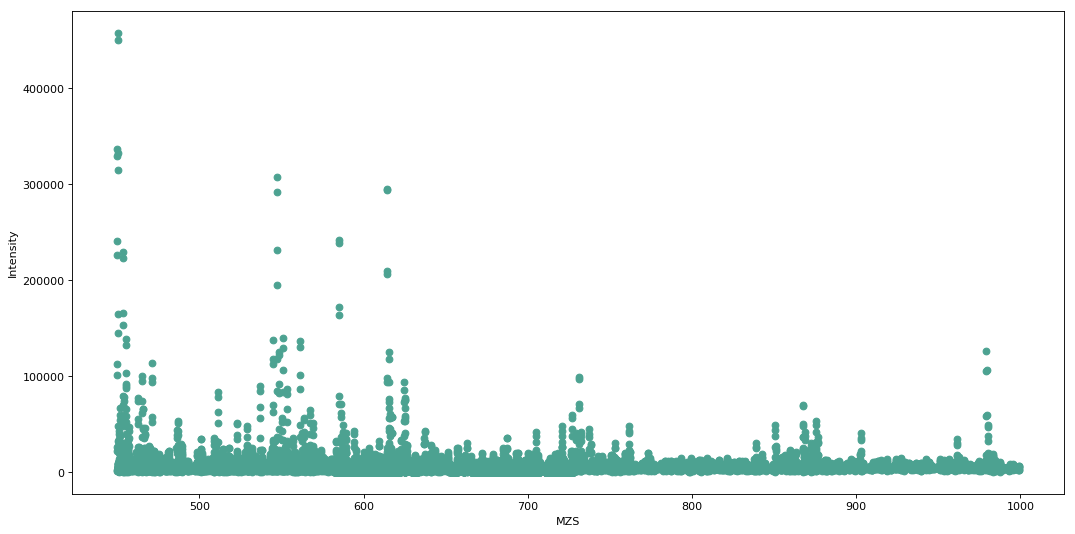

In [7]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, scatter
x = df_mass.iloc[:, 0]
y = df_intensities.iloc[:, 0]
plt.figure(1)
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
colors = np.random.rand(3)
scatter(x.values, y.values,  c=colors)
plt.xlabel('MZS')
plt.ylabel('Intensity')

## Recap:

Our control data consists of intensities (y axis) and mass-to-charge ratios (x axis). This data is is located in two dataframes: df_mass and df_intensities. Each column in these dataframes represent a sample. Each sample represents a pixel in the image. An image has a dimension around 30x30 pixels. We have illustrated this in the diagram below:

![title](img/pixel.png?1)

# Step 3:
# Let's Clean Some Data

As you have seen, our data set is quite large. Furthermore, for a given pixel, there is a lot of data we do not need. We are interested in the "peak" intensities for a given pixel. This will tell us the most abundant molecules for a given tissue region. In order to reduce our data set, we will use the signal function from scipy to find the indexes where the peaks occur. We will then filter the data by these peaks.

Execute the following cell to find the peaks and graph the resulting data:

In [69]:
import scipy.signal as signal

def find_pixel_peaks(x, y):
    pixel = pd.DataFrame({'mzs': x.values, 'intensities': y.values})
    peaks = signal.find_peaks(y, height=50000)
    pixel = pixel[pixel.index.isin(peaks[0])]
    return pixel

pixel_peaks = find_pixel_peaks(df_mass.iloc[:, 0], df_intensities.iloc[:, 0])
plt.figure(2)
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
scatter(pixel['mzs'], pixel['intensities'],  c=[0.00903845, 0.27883565, 0.57728387, 0.68528783])
plt.xlabel('MZS')
plt.ylabel('Intensity')

NameError: name 'pixel' is not defined

<Figure size 432x288 with 0 Axes>

<Figure size 1280x640 with 0 Axes>

As you can see, the signal function finds the peak intensities. We set a hard threshold of 50,000, meaning the function not consider anything below a peak. Note: for this purposes of this exercise this threshold was set by observation. This will eventually allow us to use sparse regularization to find the important features.

### Data Alignment issues

Our goal will eventually be to compare the control data to the injured data. Another data issue is that our MZS axes may not align when combining the control and sample data to do a regression. In order to fix this, we will bin the data. For each bin, we will add all intensities that fall in the bin's range. Other combination mathods, such as taking the mean, median, and max, could also be used. For the purposes of this exercise, we will only consider adding the intensities.

Execute the code below. The following code will iterate over each pixel in the image and find the peaks. After finding the peaks of each pixel, we will make a linspace of 50 bins. We then iterate over the bins, find all intensities in that range, and sum them together.

#### Note: the following code may take up to 3 min to run

In [10]:
from numpy import linspace

# FIND THE NUMBER OF SAMPLES
pixel_count = len(df_mass.columns)

# CREATE A DATAFRAME THAT WILL HOLD ALL FILTER PIXELS
master_df = pd.DataFrame()

# FIND PEAKS FOR EACH PIXEL, ADD TO MASTER_DF
for i in range(pixel_count):
    pixel_x = df_mass.iloc[:, i]
    pixel_y = df_intensities.iloc[:, i]
    df = find_pixel_peaks(pixel_x, pixel_y)
    df['pixel_id'] = i
    master_df = master_df.append(df, ignore_index=True)

# NUMBER OF BINS FOR THE MZS AXIS
number_of_bins = 50
# PHYSICAL MIN AND MAX OF AXIS
min_mzs = 450
max_mzs = 1000
# MAKE THE LINSPACE
bins = linspace(min_mzs, max_mzs, number_of_bins)
col_set = list(range(pixel_count))

# CREATE NEW DATAFRAME WHERE COLUMNS ARE THE BINS
aggregated_df = pd.DataFrame(columns=list(bins[:-1]))

for i in col_set:
    curr_pixel = master_df[master_df['pixel_id'] == i]
    pixel_binned = {}
    for index in range(1, len(bins)):
        lower_bound = bins[index - 1]
        upper_bound = bins[index]
        curr_bin = curr_pixel[curr_pixel['mzs'].between(lower_bound, upper_bound)]
        bin_intensity = curr_bin['intensities'].sum()
        pixel_binned[lower_bound] = bin_intensity
    temp = pd.DataFrame([pixel_binned])
    aggregated_df = aggregated_df.append(temp, ignore_index=True)

### Run the following code. Inspect the aggregated_df data. What do you notice about the shape?

In [11]:
aggregated_df.head()

,450.0,461.2244897959184,472.44897959183675,483.6734693877551,494.8979591836735,506.1224489795918,517.3469387755102,528.5714285714286,539.795918367347,551.0204081632653,...,887.7551020408164,898.9795918367347,910.204081632653,921.4285714285714,932.6530612244899,943.8775510204082,955.1020408163265,966.3265306122449,977.5510204081633,988.7755102040817
0,1467563.610,355378.170,0.0,52734.223,0.0,83385.85,51059.04,89987.20,765877.045,223312.37,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,126077.070,0.0
1,1035675.704,284779.654,0.0,150462.992,0.0,83377.26,0.00,127816.85,713317.256,242415.68,...,0.0,75023.586,0.0,0.0,0.0,0.0,0.0,0.0,233170.816,0.0
2,200856.444,0.000,0.0,0.000,0.0,0.00,0.00,0.00,0.000,0.00,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,66193.650,0.0
3,535552.444,272225.940,0.0,0.000,0.0,66007.27,0.00,0.00,228581.210,0.00,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,53630.855,0.0
4,326280.244,0.000,0.0,0.000,0.0,0.00,0.00,0.00,158971.587,0.00,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,51652.086,0.0


In [12]:
aggregated_df.values.shape

(900, 49)

As seen above, we have reduced our data set from 10,000x892 to 892x250.

# Step 4
# PCA, Clustering, and Building Classifiers

We will now use machine learning techniques that we studied in class to find the important features in our data, group them by cluster, and then try to classify injured vs uninjured samples.

Let's do it!

### PCA

We will now implement Principal Component Analysis to find the most important features in the data. Because the data processing step takes a lot of time, we have prepared the feature data sets for you using 250 bins.

#### First, import some packages:

In [72]:
from numpy import linspace, dot, transpose
from numpy.linalg import svd, pinv
from sklearn.cluster import KMeans
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV

#### Go ahead and load in the data:

In [14]:
df_control_feature_data_train = pd.read_csv('featureData/aggregated_feature_table_control_day03_01.csv', index_col=0)
df_injured_feature_data_train = pd.read_csv('featureData/aggregated_feature_table_injured_day03_01.csv', index_col=0)

####  Center, standardize, and combine the data the two datasets. 

In [22]:
df_control_feature_std = standardize_dataframe(df_control_feature_data_train)
df_injured_feature_std = standardize_dataframe(df_injured_feature_data_train)
df_feature_combined = pd.concat([df_control_feature_std, df_injured_feature_std], axis=0)
df_control_feature_std.head()

,450.0,452.20883534136544,454.41767068273094,456.6265060240964,458.83534136546183,461.04417670682733,463.2530120481928,465.4618473895582,467.6706827309237,469.87951807228916,...,977.9116465863453,980.1204819277108,982.3293172690763,984.5381526104418,986.7469879518072,988.9558232931727,991.1646586345381,993.3734939759036,995.5823293172691,997.7911646586346
0,0.928827,10.617636,0.610132,-0.293381,-0.31221,-0.034205,0.804553,-0.503369,-0.33669,-0.060366,...,1.790699,-0.408177,-0.033333,0.0,0.0,0.0,-0.597894,-0.133147,0.0,0.0
1,0.358183,6.094947,0.360997,-0.293381,-0.31221,0.019162,0.448514,-0.503369,-0.33669,-0.266148,...,2.402600,3.384116,-0.033333,0.0,0.0,0.0,-0.597894,-0.133147,0.0,0.0
2,-0.637789,-0.567337,-0.857177,-0.293381,-0.31221,-0.821566,-0.493169,-0.503369,-0.33669,-0.828612,...,0.344550,-0.408177,-0.033333,0.0,0.0,0.0,-0.597894,-0.133147,0.0,0.0
3,-0.183879,1.399723,-0.364067,-0.293381,-0.31221,-0.218896,0.590063,-0.503369,-0.33669,-0.316772,...,0.041166,-0.408177,-0.033333,0.0,0.0,0.0,-0.597894,-0.133147,0.0,0.0
4,-0.474041,-0.567337,-0.496392,-0.293381,-0.31221,-0.821566,-0.493169,-0.503369,-0.33669,-0.828612,...,-0.006620,-0.408177,-0.033333,0.0,0.0,0.0,-0.597894,-0.133147,0.0,0.0


### SVD and K-Means on the Control Feature Set

We will now try K-Means on the control data set, and try to plot the clusters using a rank-2 approximation.First, we find the SVD. Next, we will run K-Means on the resulting coordinates with three clusters. We will then plot the resulting K-Means labels using plt.imshow.

#### plt.imshow: this plotting function takes the cluster labels for each pixel and plots them. Therefore, our image will have pixels that have 1 of 3 colors. Each color will correspond to the assigned cluster

In [33]:
# FIND THE SVD, NOTE V IS RETURNED TRANSPOSED
[U, S, V] = svd(df_control_feature_std.values)
# CREATE A DIAG MATRIX
S_DIAG = np.diag(S)
# COMPUTE THE RANK 2 APPOIMATION TO FIND THE COORDINATES, NOTE OUR FEATURE VECTORS ARE ROWS
dim_red_data = dot(U[:, :2], S_DIAG[:2, :2])

In [34]:
# RUN KMeans WITH 3 CLUSTERS
kmeans = KMeans(n_clusters=3, n_init=15)
kmeans.fit(dim_red_data)
y_kmeans = kmeans.predict(dim_red_data)
df_clusters = pd.DataFrame(dim_red_data)
df_clusters['clusters'] = y_kmeans

Text(0,0.5,'Singular Vector 2')

<Figure size 432x288 with 0 Axes>

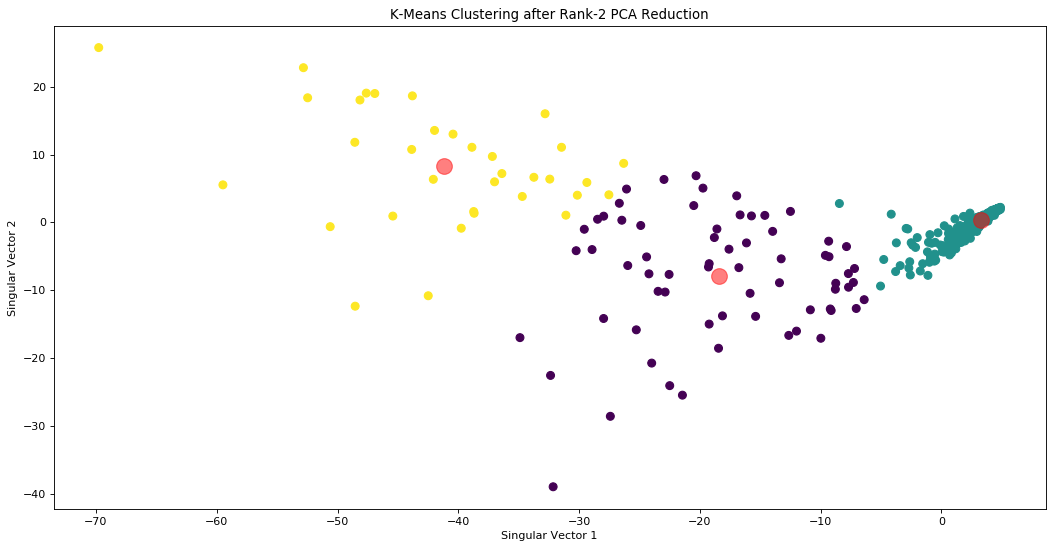

In [38]:
x = df_clusters[0]
y = df_clusters[1]

centers = kmeans.cluster_centers_
centers[:, 0], centers[:, 1] = centers[:, 0], centers[:, 1]
plt.figure(2)
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(x, y, c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
plt.title('K-Means Clustering after Rank-2 PCA Reduction')
plt.xlabel('Singular Vector 1')
plt.ylabel('Singular Vector 2')

#### We have 3 clusters and 3 respective centroids. Each data point represents a pixel. 

### Let's try and take each pixels assigned cluster label and plot it as an image:

<Figure size 432x288 with 0 Axes>

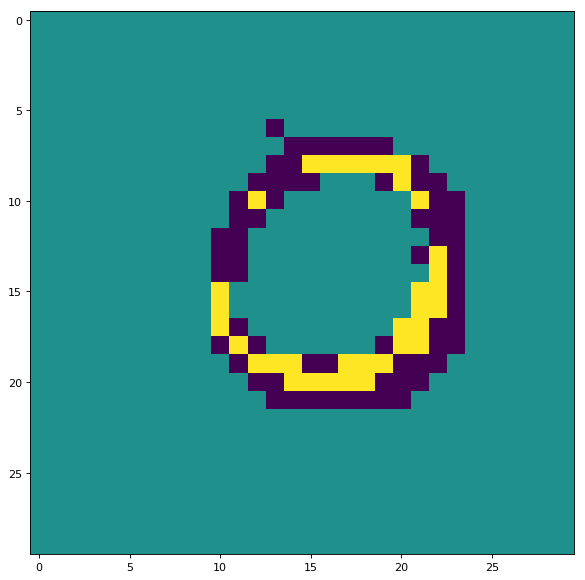

In [36]:
plt.figure(3)
plt.figure(figsize=(9, 9), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(y_kmeans.reshape(30, 30))
plt.show()

### Look familiar?

<img src="img/3D-1 control.png" style="width: 200px;"/>

As you can see, the teal pixels correspond to the white space. Going forward, we will use K-Means to remove these data-points from our matrix, simply because we are not interested in classifying them.

## Now let's do it for the combined data set so we can build a classifier

Run the get_k_means_labels() function. This will run K-Means on the aggregated data. Next, it will filter the whitespace (teal pixels). It will also return the labels (clusters) for each pixel. 

In [45]:
vec_filtered_data, labels = get_k_means_labels(df_feature_combined)

### Simple Linear Regression

In [141]:
def least_sqaures_linear_classifier(vec_combined_features, vec_combined_labels):
    reg = LinearRegression(fit_intercept=True, normalize=False)
    reg.fit(vec_combined_features, vec_combined_labels)
    w = reg.coef_
    return w, reg.intercept_ 

In [142]:
x = vec_filtered_data[:, 0]
y = vec_filtered_data[:, 1]
w, intercept = least_sqaures_linear_classifier(vec_filtered_data, labels)

In [143]:
w

array([ 0.02165243, -0.01278003])

Not too good!

### Adding an L1 Regularizer

In [117]:
def least_sqaures_lasso_regularizer(vec_combined_features, vec_combined_labels):
    lasso = Lasso(fit_intercept=True)
    parameters = {'alpha': [1e-15,1e-10, 1e-2, 1, 5, 10, 20, 50, 100, 10000]}
    lasso_regressor = GridSearchCV(lasso, parameters, scoring="neg_mean_absolute_error", cv=5)
    lasso_regressor.fit(vec_combined_features, vec_combined_labels)
    return lasso_regressor.best_estimator_.coef_, lasso_regressor.best_estimator_.intercept_

In [118]:
w_lasso, intercept_lasso = least_sqaures_lasso_regularizer(vec_filtered_data, labels)

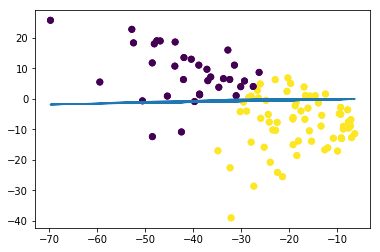

In [119]:
plt.scatter(x, y, c=labels)
plt.plot(x, dot(vec_filtered_data, w_lasso))

In [120]:
def least_sqaures_ridge_regression(vec_combined_features, vec_combined_labels):
    from sklearn.linear_model import Ridge
    ridge = Ridge(fit_intercept=True)
    parameters = {'alpha': [1e-10, 1e-2, 1, 5, 10, 20, 50, 100]}
    ridge_regressor = GridSearchCV(ridge, parameters, scoring="neg_mean_squared_error", cv=5)
    ridge_regressor.fit(vec_combined_features, vec_combined_labels)
    return ridge_regressor.best_estimator_.coef_, ridge_regressor.best_estimator_.intercept_

In [121]:
w_ridge, intercept_ridge = least_sqaures_ridge_regression(vec_filtered_data, labels)

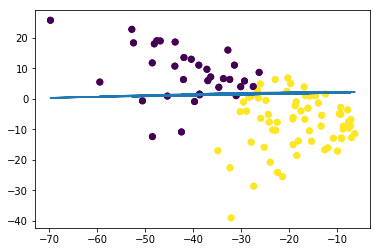

In [123]:
plt.scatter(x, y, c=labels)
plt.plot(x, dot(vec_filtered_data, w_ridge) + intercept_ridge)

In [124]:
vec_filtered_data.shape

(200, 2)

### SVM for Classifying Pixels

In [140]:
intercept_ridge

2.194742077648185

# Appendix and Helper Functions

In [16]:
def standardize_dataframe(df):
    df = (df - df.mean()) / df.std()
    df = df.fillna(0)
    return df
    

In [39]:
def get_k_means_labels(df_feature_agg_std):
    # FIND THE SVD, NOTE V IS RETURNED TRANSPOSED
    [U, S, V] = svd(df_feature_agg_std.values)
    # CREATE A DIAG MATRIX
    S_DIAG = np.diag(S)
    # COMPUTE THE RANK 2 APPOIMATION TO FIND THE COORDINATES, NOTE OUR FEATURE VECTORS ARE ROWS
    vec_dim_red_data = dot(U[:, :2], S_DIAG[:2, :2])
    
    kmeans = KMeans(n_clusters=3, n_init=15)
    kmeans.fit(vec_dim_red_data)
    y_kmeans = kmeans.predict(vec_dim_red_data)
    df_clusters = pd.DataFrame(vec_dim_red_data)
    df_clusters['clusters'] = y_kmeans

    unique, counts = np.unique(y_kmeans, return_counts=True)
    cluster_counts = dict(zip(unique, counts))
    white_space_key = max(cluster_counts, key=cluster_counts.get)
    df_remove_white_space = df_clusters[df_clusters['clusters'] != white_space_key]
    labels = df_remove_white_space['clusters']
    del df_remove_white_space['clusters']
    return df_remove_white_space.values, labels

In [46]:
def plot_svc_decision_function(model, clusters, labels, ax=None, plot_support=True):
    """
    Code was adopted from https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
    :param model:
    :param clusters:
    :param labels:
    :param ax:
    :param plot_support:
    :return:
    """
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()


    x = clusters[:, 0]
    y = clusters[:, 1]
    # create grid to evaluate model
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)